# Generalization to other model sizes/seq. summary types

## Import packages

In [1]:
save = True

In [2]:
#import packages
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
import json

In [3]:
# import from other scripts
import plot_utils
from plot_utils import *
import stats_utils

## Define approach configuration

In [4]:
model_identifier="distilgpt2"

In [5]:
#whether or not to include control condition random nouns (used for SI)
randomnouns=False
length_control=False

In [6]:
# get setting
emb_context="Passage"
split_coord="Sentence"
testonperturbed=False

In [7]:
# function check (this is done in the main function below!)
scores_df = plot_utils.get_best_scores_df(model_identifier=model_identifier,
                                          emb_context=emb_context,
                                          split_coord=split_coord,
                                          testonperturbed=testonperturbed,
                                          randomnouns=randomnouns,length_control=length_control)
scores_df

,score,error,condition,category,category_group
0,0.277694,0.010816,original,original,word-order
1,0.279128,0.010759,scrambled1,word-order,word-order
2,0.279148,0.011684,scrambled3,word-order,word-order
3,0.274231,0.007990,scrambled5,word-order,word-order
4,0.281711,0.015259,scrambled7,word-order,word-order
5,0.253315,0.012616,backward,word-order,word-order
6,0.281848,0.019458,lowpmi,word-order,word-order
7,0.270675,0.016286,lowpmi-random,word-order,word-order
8,0.209659,0.013931,random-wl,control,word-order
9,0.277694,0.013317,original,original,information-loss


## Plot

In [8]:
plot_utils.figure_setup()

In [9]:
#define colors
if randomnouns:
    CAT2COLOR["information-loss"] = sns.cubehelix_palette(6, start=2, rot=0, dark=0.2, light=.85, reverse=True)

### 3. Define plot function

In [10]:
#!pip install patchworklib

In [11]:
def barplot_multi(list_of_model_identifiers, scores_df, emb_context="Passage", split_coord="Sentence", testonperturbed=False):

    #define global figure settings
    import matplotlib
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    matplotlib.rcParams['svg.fonttype'] = 'none'

    custom_params = {"axes.spines.right": False,
                     "axes.spines.top": False,
                     'ytick.left': True,
                     'xtick.bottom': True,
                     'grid.linestyle': ""  # gets rid of horizontal lines
                     }
    sns.set_theme(font_scale=1, style="white", rc=custom_params)
    #get proportions for subplot width
    categories = ["original", "word-order", "information-loss", "semantic-distance", "control"]
    props = [len(scores_df.loc[scores_df["category"] == cat])/len(scores_df) for cat in categories]

    fig = plt.figure(constrained_layout=True, figsize=(8, 15))
    g = sns.catplot(data=scores_df, x='condition', y='score', hue='model', col='category', kind='bar', sharex=False,
                    facet_kws={'gridspec_kws': {"width_ratios": props}}, aspect=0.35, legend_out=True)
 
          
   # g.map(plt.errorbar, "condition", "score", "error", ls='none', color="k", capsize=5)
    g.set_titles(col_template="{col_name}")
    g.set_xlabels("")
    g.set_ylabels("Brain predictivity")
    g.set_xticklabels(rotation=80)
        
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 0.75))
    g.fig.tight_layout()
    
    savename = f"match2brain_{'+'.join(list_of_model_identifiers)}_testonperturbed={testonperturbed}"

    if save:
        g.savefig(f'results_paper_revision/SupplementaryInformation/{savename}.svg', dpi=180)
        g.savefig(f'results_paper_revision/SupplementaryInformation/{savename}.png', bbox_inches='tight', dpi=180)

    plt.show()

In [12]:
import pandas as pd

CAT2COND, COND2CAT = plot_utils.get_conditions()

def main_multi(list_of_model_identifiers, emb_context="Passage", split_coord="Sentence", testonperturbed=False):
    frames = []

    for model in list_of_model_identifiers:
        print(model)
        m_scores_df = plot_utils.get_best_scores_df(model, emb_context=emb_context,
                                    split_coord=split_coord, testonperturbed=testonperturbed)
        
        #drop duplicate lines (original/random-wl)
        for cond in ['original', 'random-wl']:
            scores = m_scores_df.loc[m_scores_df['condition'] == cond]['score']
            errors = m_scores_df.loc[m_scores_df['condition'] == cond]['error']
            score = np.mean(scores)
            error = np.mean(errors)

            #delete duplicate rows
            m_scores_df = m_scores_df[m_scores_df.condition != cond]

            # create a new row to insert at the first index
            new_row = pd.Series({'score': score, 'error': error, 'condition': cond, 'category': COND2CAT[cond],
                                'category_group' : 'all'})

            if cond == 'original':
                # insert the new row at the first index
                m_scores_df.loc[-1] = new_row
                m_scores_df.index = m_scores_df.index + 1
                m_scores_df = m_scores_df.sort_index()
            else:
                # insert the new row at the last index
                m_scores_df.loc[len(m_scores_df)] = new_row
        
        m_scores_df["model"] = model
        frames.append(m_scores_df)
    
    scores_df = pd.concat(frames)
    #Rename conditions according to new names:
    scores_df['condition'] = scores_df['condition'].map(plot_utils.COND2LABEL)
    
    barplot_multi(list_of_model_identifiers, scores_df, emb_context=emb_context,
            split_coord=split_coord, testonperturbed=testonperturbed)

In [13]:
plotting_models = ["distilgpt2", "gpt2", "gpt2-xl"]

distilgpt2
gpt2
gpt2-xl


<Figure size 576x1080 with 0 Axes>

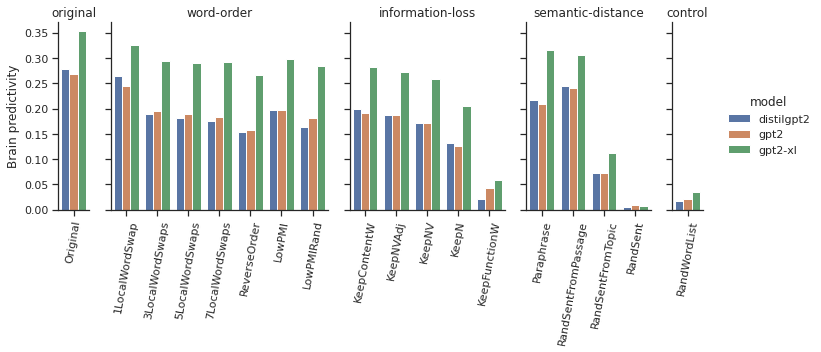

In [14]:
main_multi(plotting_models, testonperturbed=True)

distilgpt2
gpt2
gpt2-xl


<Figure size 576x1080 with 0 Axes>

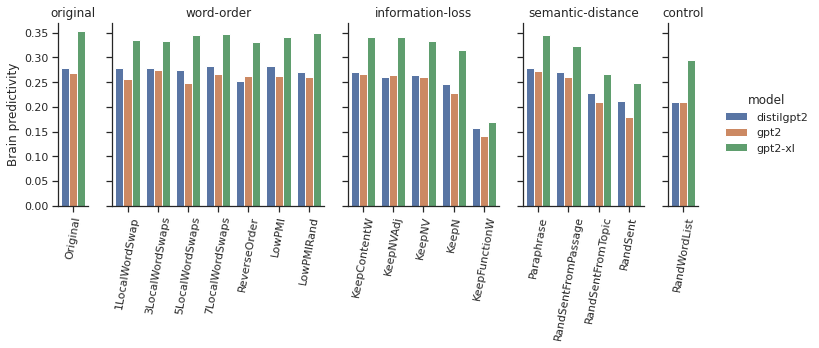

In [15]:
main_multi(plotting_models)

# All models barplot

distilgpt2
distilgpt2-avgtoken


<Figure size 576x1080 with 0 Axes>

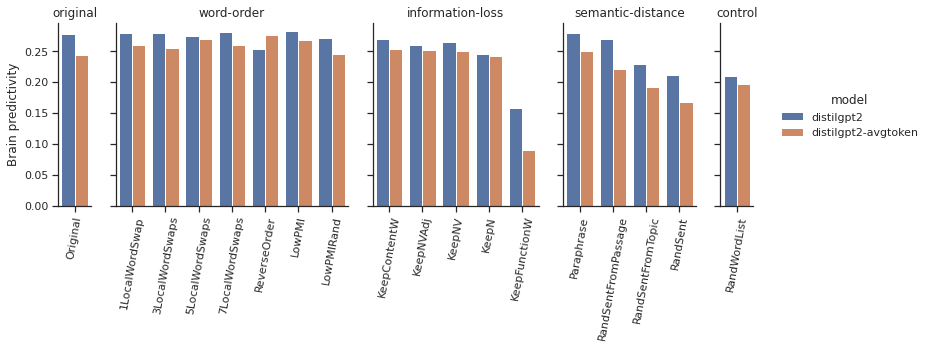

In [16]:
main_multi(["distilgpt2","distilgpt2-avgtoken"])

distilgpt2
distilgpt2-avgtoken


<Figure size 576x1080 with 0 Axes>

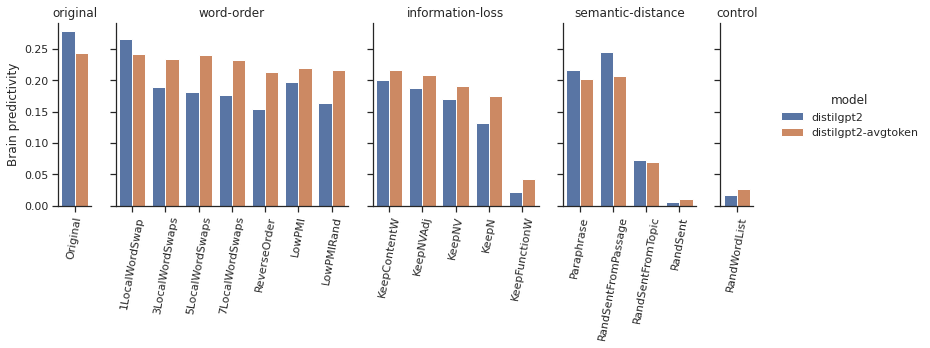

In [17]:
main_multi(["distilgpt2","distilgpt2-avgtoken"], testonperturbed=True)